In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [101]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
%matplotlib inline

In [103]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
  dftest = adfuller(df, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

  print("----------")

  return dftest[1]

In [197]:
def correct(df,column,factor):
    clone_column = df[column]
    
    df["diff"] = clone_column.diff()
    df["diff_abs"] = df["diff"].apply(np.absolute)
    diff_mean = df["diff_abs"].dropna().mean()
    
    threshold_factor = factor 
    anomalies = df.loc[ ~(df["diff"].isnull()) & (df["diff_abs"].dropna() > threshold_factor * diff_mean)]
    
    df["new"] = clone_column

    for i in range(len(anomalies)):
        df_od_curr = df.loc[ df["date"] == anomalies.iloc[i]["date"] ]
        df_od_prev = df.loc[df_od_curr.index -1]

        od_curr_index = df_od_curr.index[0]

        od_curr = df_od_curr.iloc[0][column]
        od_prev = df_od_prev.iloc[0][column]
        shifter = round(od_curr - od_prev , 2)

        for j in range(0,od_curr_index):
            df.loc[j,"new"] += [shifter]

    return df["new"]

In [144]:
def limit_range(df, column, min, max):
    df.loc[df[df[column] < min].index,column] = min
    df.loc[df[df[column] > max].index,column] = max

    return df[column]

In [237]:
def correct_with_range(df,column,factor,min,max):
    clone_column = df[column]
    
    df["diff"] = clone_column.diff()
    df["diff_abs"] = df["diff"].apply(np.absolute)
    diff_mean = df["diff_abs"].dropna().mean()
    
    threshold_factor = factor 
    anomalies = df.loc[ ~(df["diff"].isnull()) & (df["diff_abs"].dropna() > threshold_factor * diff_mean)]
    
    df["new"] = clone_column

    for i in range(len(anomalies)):
        df_od_curr = df.loc[ df["date"] == anomalies.iloc[i]["date"] ]
        df_od_prev = df.loc[df_od_curr.index -1]

        od_curr_index = df_od_curr.index[0]

        od_curr = df_od_curr.iloc[0][column]
        od_prev = df_od_prev.iloc[0][column]
        shifter = round(od_curr - od_prev , 2)

        for j in range(0,od_curr_index):
            df.loc[j,"new"] += [shifter]

            if df.loc[j,"new"] > [max]:
                df.loc[j,"new"] = [max]
            elif df.loc[j,"new"] < [min]:
                df.loc[j,"new"] = [min]
        
    return df["new"]

In [105]:
def limit_range(df,column,min,max):
    return

In [106]:
df_1 = pd.read_csv("WatKhlongKhuan.csv")
# df_1

In [107]:
df_2 = pd.read_csv("WatKhlongKhuan (3).csv")
# df_2

In [108]:
df_1.rename(columns={"Date":"date",
    "Temperature":"temperature",
    "ph":"pH",
    "EC":"ec"},
    inplace=True)

# df_1

In [109]:
df_2.rename(columns = {
    "ph":"pH"
    },
    inplace=True)

In [110]:
df_1["date"] = pd.to_datetime(df_1["date"], format = "%m/%d/%Y %H:%M")

In [111]:
df_2["date"] = pd.to_datetime(df_2["date"], format = "%Y-%m-%d %H:%M")

In [112]:
df = pd.concat([df_1,df_2])
# df

In [113]:
df.drop(["place","salinity"], axis=1, inplace=True)

In [114]:
df.drop_duplicates(subset=['date'], keep='first', inplace=True)

In [115]:
df.sort_values("date",inplace=True)
df.reset_index(drop=True,inplace=True)

In [116]:
df = df.resample("1H",on="date").mean().interpolate(method="time")
df.reset_index(inplace=True)

In [117]:
df.loc[df[df["pH"] < 1].index,"pH"] = 1
df.loc[df[df["pH"] > 14].index,"pH"] = 14

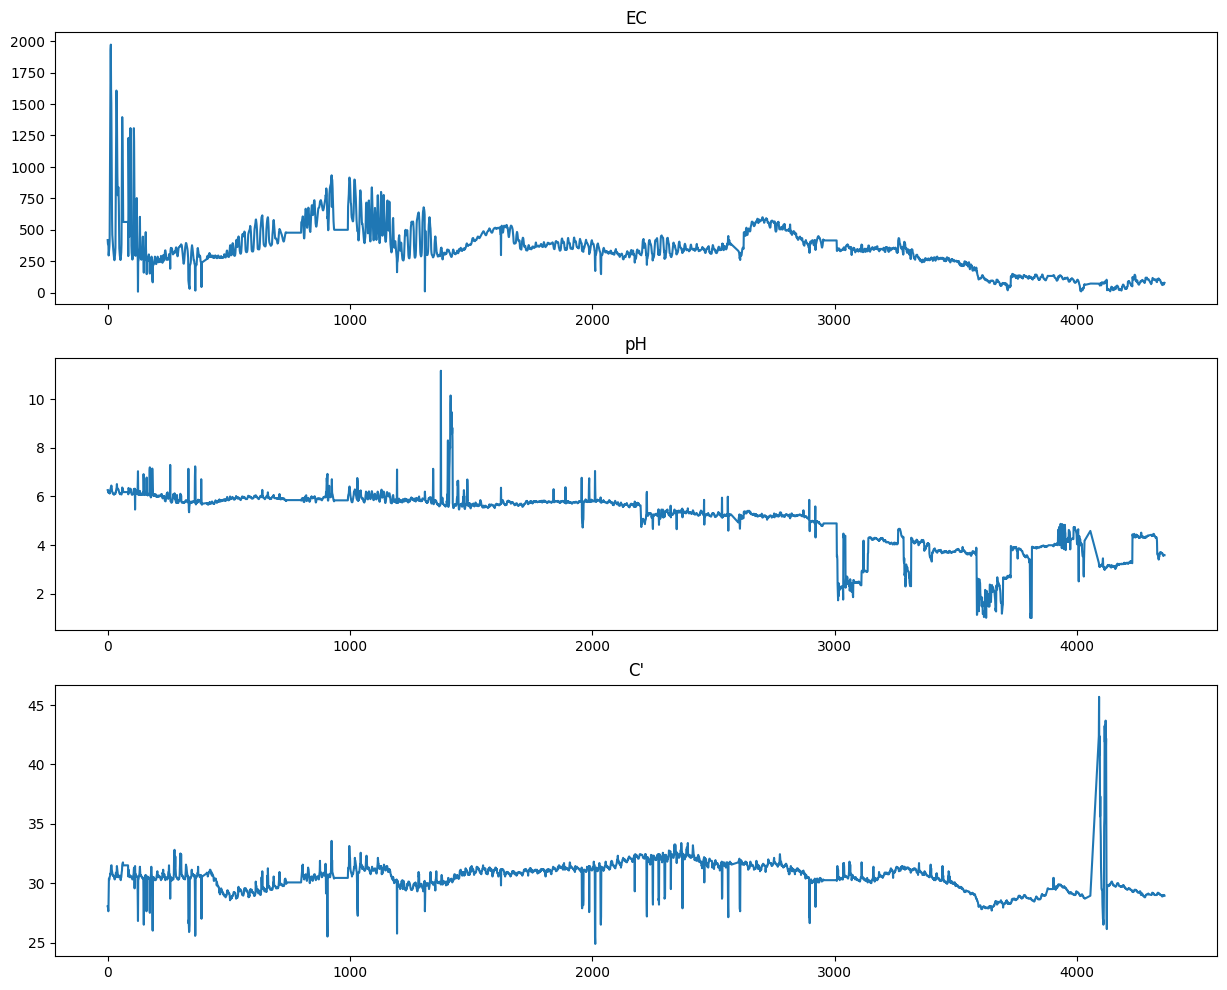

In [118]:
plt.figure(figsize = (15, 12))

plt.subplot(3,1,1)
plt.plot(df["ec"])
plt.title('EC')

plt.subplot(3,1,2)
plt.plot(df["pH"])
plt.title('pH')

plt.subplot(3,1,3)
plt.plot(df["temperature"])
plt.title('C\'')

plt.show()

In [119]:
df_train = df.copy()
# df_train = df.drop(["pH","temperature"],axis=1)
# df_train = df.drop(["pH","ec"],axis=1)
# df_train = df.drop(["ec","temperature"],axis=1)

df_train.reset_index(inplace=True)
df_train

,index,date,temperature,pH,ec
0,0,2022-03-15 00:00:00,28.06,6.26,419.30
1,1,2022-03-15 01:00:00,28.06,6.23,390.10
2,2,2022-03-15 02:00:00,27.69,6.20,380.10
3,3,2022-03-15 03:00:00,27.63,6.24,376.30
4,4,2022-03-15 04:00:00,29.25,6.14,296.70
...,...,...,...,...,...
4357,4357,2022-09-12 13:00:00,29.00,3.57,72.90
4358,4358,2022-09-12 14:00:00,29.00,3.60,66.03
4359,4359,2022-09-12 15:00:00,29.00,3.58,70.98
4360,4360,2022-09-12 16:00:00,29.00,3.58,77.63


In [120]:
# df_train = df_train.resample("1H",on="date").mean().interpolate(method="time")
# df_train.reset_index(inplace=True)

In [121]:
# df_train["ec_diff"] = df_train["ec"].diff()

In [122]:
# adf_test(df_train["ec"])
# adf_test(df_train["ec_diff"].dropna())

In [123]:
# plt.figure(figsize=(10,8))
# df_train["ec"].plot(label = "original")
# df_train["ec_diff"].plot(label="1st diff")
# plt.legend()

In [124]:
# df_train["ec_diff_abs"] = df_train["ec_diff"].apply(np.absolute)

In [125]:
# ec_diff_mean = df_train["ec_diff_abs"].dropna().mean()

In [126]:
# anomaly_factor = .5

In [127]:
# anomalies = df_train.loc[ ~(df_train["ec_diff"].isnull()) & (df_train["ec_diff_abs"].dropna() > anomaly_factor * ec_diff_mean)]

In [128]:
# df_train["ec_new"] = df_train["ec"]

In [129]:
# df_od_curr = df_train.loc[ df_train["date"] == anomalies.iloc[0]["date"] ]
# df_od_prev = df_train.loc[od_curr.index -1]

# od_curr_index = df_od_curr.index[0]

# od_curr = df_od_curr.iloc[0]["ec"]
# od_prev = df_od_prev.iloc[0]["ec"]
# shifter = round(od_curr - od_prev, 2)

In [130]:
# for i in range(len(anomalies)):
#     df_od_curr = df_train.loc[ df_train["date"] == anomalies.iloc[i]["date"] ]
#     df_od_prev = df_train.loc[df_od_curr.index -1]

#     od_curr_index = df_od_curr.index[0]

#     od_curr = df_od_curr.iloc[0]["ec"]
#     od_prev = df_od_prev.iloc[0]["ec"]
#     shifter = round(od_curr - od_prev , 2)

#     for j in range(0,od_curr_index):
#         df_train.loc[j,"ec_new"] += [shifter]

In [183]:
df_train["ec_new_4"] = correct(df_train,"ec",4)
df_train["ec_new_3"] = correct(df_train,"ec",3)
df_train["ec_new_2"] = correct(df_train,"ec",2)
df_train["ec_new_1"] = correct(df_train,"ec",1)
df_train["ec_new_.5"] = correct(df_train,"ec",.5)

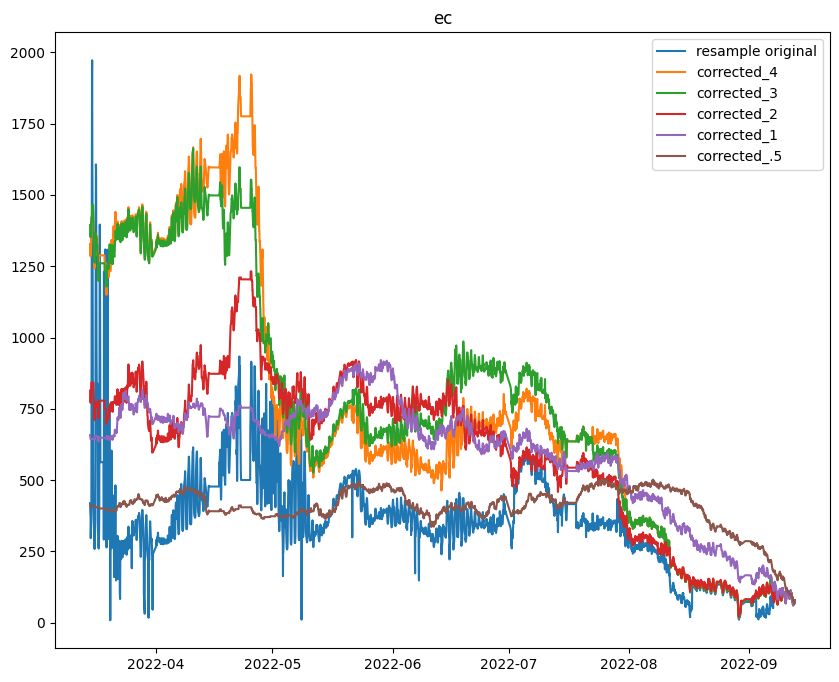

In [184]:
plt.figure(figsize=(10,8))
plt.title("ec")
plt.plot(df_train["date"], df_train["ec"], label="resample original", color = "b")
plt.plot(df_train["date"], df_train["ec_new_4"], label="corrected_4")
plt.plot(df_train["date"], df_train["ec_new_3"], label="corrected_3")
plt.plot(df_train["date"], df_train["ec_new_2"], label="corrected_2")
plt.plot(df_train["date"], df_train["ec_new_1"], label="corrected_1")
plt.plot(df_train["date"], df_train["ec_new_.5"], label="corrected_.5")
plt.legend()

In [215]:
print(df_train["pH"].diff().dropna().abs().mean())
print(df_train["pH"].diff().dropna().abs().min())
print(df_train["pH"].diff().dropna().abs().max())

0.06612856378506458
0.0
5.42


In [238]:
df_train["pH_new_4"] = correct_with_range(df_train,"pH",4,1,14)
df_train["pH_new_3"] = correct_with_range(df_train,"pH",3,1,14)
df_train["pH_new_2"] = correct_with_range(df_train,"pH",2,1,14)
df_train["pH_new_1"] = correct_with_range(df_train,"pH",1,1,14)
df_train["pH_new_.5"] = correct_with_range(df_train,"pH",.5,1,14)

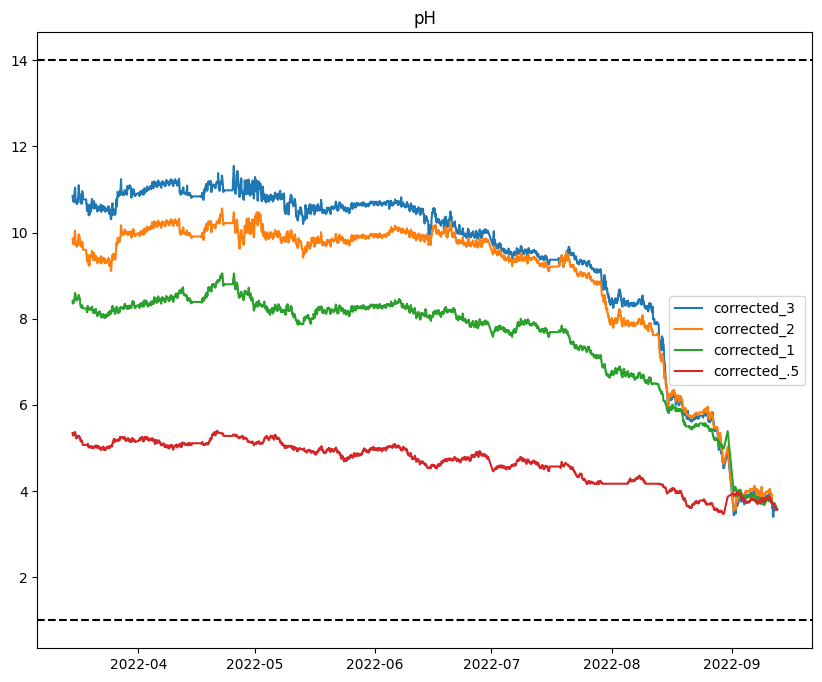

In [239]:
plt.figure(figsize=(10,8))
plt.title("pH")
plt.axhline(y = 14, color = "k", linestyle = "--")
plt.axhline(y = 1, color = "k", linestyle = "--")
plt.plot(df_train["date"], df_train["pH"], label="resample original", color = "b")
plt.plot(df_train["date"], df_train["pH_new_4"], label="corrected_4", color = "g")
plt.plot(df_train["date"], df_train["pH_new_3"], label="corrected_3")
plt.plot(df_train["date"], df_train["pH_new_2"], label="corrected_2")
plt.plot(df_train["date"], df_train["pH_new_1"], label="corrected_1")
plt.plot(df_train["date"], df_train["pH_new_.5"], label="corrected_.5")
plt.legend()

In [165]:
# df_train.drop(["pH_new_.5"], axis=1, inplace=True)
# df_train

,index,date,temperature,pH,ec,diff,diff_abs,new,ec_new_4,ec_new_3,ec_new_2,ec_new_1,ec_new_.5
0,0,2022-03-15 00:00:00,28.06,6.26,419.30,NaN,NaN,2.08,1327.50,1394.40,814.02,658.19,413.39
1,1,2022-03-15 01:00:00,28.06,6.23,390.10,-0.03,0.03,2.08,1298.30,1365.20,784.82,658.19,413.39
2,2,2022-03-15 02:00:00,27.69,6.20,380.10,-0.03,0.03,2.08,1288.30,1355.20,774.82,648.19,413.39
3,3,2022-03-15 03:00:00,27.63,6.24,376.30,0.04,0.04,2.08,1284.50,1351.40,771.02,644.39,409.59
4,4,2022-03-15 04:00:00,29.25,6.14,296.70,-0.10,0.10,2.08,1284.50,1351.40,771.02,644.39,409.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,4357,2022-09-12 13:00:00,29.00,3.57,72.90,-0.02,0.02,3.57,72.90,72.90,72.90,72.90,72.90
4358,4358,2022-09-12 14:00:00,29.00,3.60,66.03,0.03,0.03,3.60,66.03,66.03,66.03,66.03,66.03
4359,4359,2022-09-12 15:00:00,29.00,3.58,70.98,-0.02,0.02,3.58,70.98,70.98,70.98,70.98,70.98
4360,4360,2022-09-12 16:00:00,29.00,3.58,77.63,0.00,0.00,3.58,77.63,77.63,77.63,77.63,77.63


In [134]:
# datetime = pd.DataFrame(pd.date_range(start="3/15/2022 00:00",end="9/12/2022 23:50",freq="1H").rename("date"))
# # datetime.rename(columns={"0":"date_time"},inplace=True)
# datetime